# 타이타닉 생존자 예측 (v1)
- 입력: 데이터의 독립변인은 생존을 제외한 전부
- 결과: 생존자를 예측(0 / 1)

## 과정
1. 데이터 불러오기
2. 데이터 전처리
3. 데이터 분할
4. 데이터 정규화
---
5. 학습/검증/테스트 데이터(텐서 변경)
6. 모델 생성(a. 베이스라인, b. 개선)
7. 학습
8. 예측
9. 평가

> 주의: 5번부터는 Pytorch를 사용하여 구현

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    # 형태(행, 열 크기)
    # - 열(독립변인, 측정값)
    # - 행(종속변인, 관측값)
    # 자료형(info)
    # 컬럼 이름(columns.tolist())
    print(f'\n 결측치 : {df.isnull().sum()}')
    return df

In [3]:
df = load_data('./data/titanic/train.csv')


 결측치 : PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
df.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [5]:
def preprocess_data(df):
    df = df.copy()
    target_col = "Survived"
    columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]

    if target_col in df.columns:
        df = df.dropna(subset=[target_col])

    df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])

    if "Sex" in df.columns:
        s = df["Sex"].astype(str).str.lower().str.strip()
        df["Sex"] = s.map({"male": 0, "female": 1})

    if "Embarked" in df.columns:
        df = pd.get_dummies(df, columns=["Embarked"], prefix="Embarked", dtype=int)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if target_col in df.columns:
        feature_cols = [c for c in numeric_cols if c != target_col]
        y = df[target_col].copy()
    else:
        feature_cols = numeric_cols
        y = None

    X = df[feature_cols].copy()

    X = X.fillna(X.mean(numeric_only=True))

    if y is None:
        return X.values, None, feature_cols
    return X.values, y.values, feature_cols


In [6]:
X, y, feature_cols = preprocess_data(df)

In [7]:
X, feature_cols

(array([[ 3.        ,  0.        , 22.        , ...,  0.        ,
          0.        ,  1.        ],
        [ 1.        ,  1.        , 38.        , ...,  1.        ,
          0.        ,  0.        ],
        [ 3.        ,  1.        , 26.        , ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 3.        ,  1.        , 29.69911765, ...,  0.        ,
          0.        ,  1.        ],
        [ 1.        ,  0.        , 26.        , ...,  1.        ,
          0.        ,  0.        ],
        [ 3.        ,  0.        , 32.        , ...,  0.        ,
          1.        ,  0.        ]], shape=(891, 9)),
 ['Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Parch',
  'Fare',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S'])

# 데이터셋 분할

- X, y, train_ratio = 0.8

n_samples =len(X)
n_train = int(n_samples * train_ratio)

indexes = np.random.permuation(n_samples)
train_indexes = indexes(:n_train)
test_indexes = indexes(n_train:)

X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

return X_train, X_test, y_train, y_test

In [8]:
def split_data(X, y, train_ratio=0.8):
    n_samples = len(X)
    n_train = int(n_samples * train_ratio)

    indexes = np.random.permutation(n_samples)
    train_indexes = indexes[:n_train]
    test_indexes = indexes[n_train:]

    X_train = X[train_indexes]
    X_test = X[test_indexes]
    y_train = y[train_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = split_data(X, y)

# 데이터 정규화

(평균 = 0, 표준편차 = 1)

mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0) + 1e-8

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

return X_train_norm, X_test_norm, mean, std

In [10]:
def normalize_data(X_train, X_test):
    mean = X_train.mean(axis = 0)
    std = X_train.std(axis = 0) + 1e-8

    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std

    return X_train_norm, X_test_norm, mean, std

In [11]:
X_train_norm, X_test_norm, mean, std = normalize_data(X_train, X_test)

In [12]:
type(X_train_norm)

numpy.ndarray

# 데이터셋 만들기(텐서 변환)

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y) # 분류 문제라서 LongTenseor 사용

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# 모델 생성

In [14]:
import torch.nn as nn
class LinearClassifierModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifierModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# 모델 학습

In [15]:
def train_model(model, train_loader, criterion, optimizer, epochs = 100):
    model.train()
    loss_hist = []
    acc_hist = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

            # 측정
            epoch_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
        avg_loss = epoch_loss / len(train_loader)
        acc = 100 * correct / total
        loss_hist.append(avg_loss)
        acc_hist.append(acc)

        if (epoch + 1) % 10 == 0 :
            print(f'{epoch+1} : {avg_loss}, {acc}')

    return loss_hist, acc_hist

# 모델 평가

In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            pred = model(batch_X)
            _, predicted = torch.max(pred.data, 1)
            predictions.extend(predicted.numpy())
            actuals.extend(batch_y.numpy())
            
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    print(f"\n=== 테스트 세트 평가 ===")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")
    
    return predictions, actuals, accuracy



In [17]:
train_dataset = TitanicDataset(X_train_norm, y_train)
test_dataset = TitanicDataset(X_test_norm, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 초기 데이터의 크기와 결과에 대해서 미리 알고 있어야 함
input_dim = X_train_norm.shape[1]
num_classes = 2
model = LinearClassifierModel(input_dim, num_classes)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [19]:
loss_hist, acc_hist = train_model(model, train_loader, criterion, optimizer)

10 : 0.4421214318793753, 81.74157303370787
20 : 0.4112957715988159, 82.7247191011236
30 : 0.4036960271389588, 83.84831460674157
40 : 0.3908303166213243, 84.41011235955057
50 : 0.38949598631133203, 84.26966292134831
60 : 0.3809574933155723, 83.98876404494382
70 : 0.36476836191571277, 84.26966292134831
80 : 0.39218912500402203, 83.42696629213484
90 : 0.3802352696657181, 84.26966292134831
100 : 0.38091282028218976, 84.69101123595506


In [22]:
predictions, actuals, accuracy = evaluate_model(model, test_loader)


=== 테스트 세트 평가 ===
Accuracy: 83.24%
Correct: 149/179


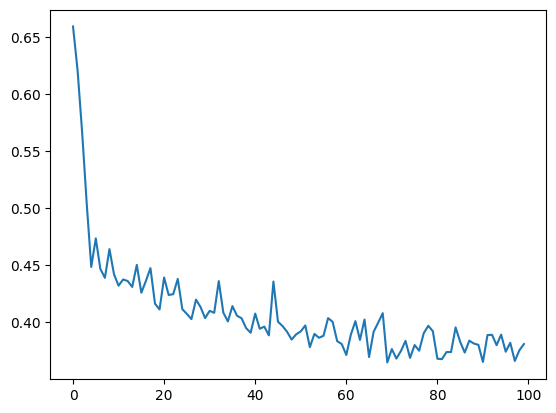

In [20]:
plt.plot(loss_hist)

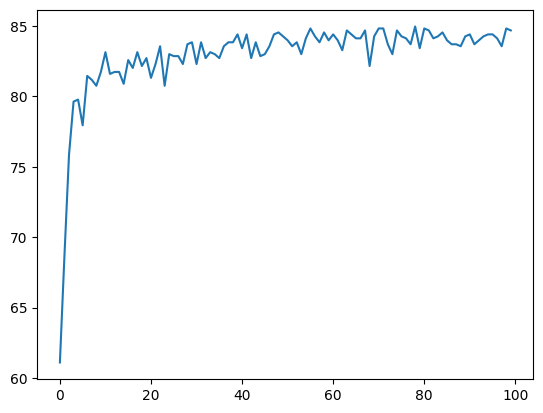

In [21]:
plt.plot(acc_hist)